# パッケージインストール

In [ ]:
!pip install -q onnx onnxruntime
!pip install -q cloths_segmentation

# モデル生成

In [ ]:
import torch
from cloths_segmentation.pre_trained_models import create_model

model = create_model("Unet_2020-10-30")
_ = model.eval();

# ONNX変換

In [3]:
def convert_to_onnx(net, file_name='output.onnx', input_shape=(224, 224), device='cpu', verbose=False):
    input = torch.randn(1, 3, input_shape[1], input_shape[0]).to(device)
    torch.onnx.export(
        net,
        input,
        file_name,
        verbose=verbose,
        opset_version=16,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            "input": {0: "batch_size", 2: "height", 3:"width"}
        }
    )

In [4]:
convert_to_onnx(model, 'cloths_segmentation.onnx')

# サンプル画像ダウンロード

In [ ]:
!wget https://user0514.cdnw.net/shared/img/thumb/kagamiHFKE5076_TP_V4.jpg -O sample.jpg

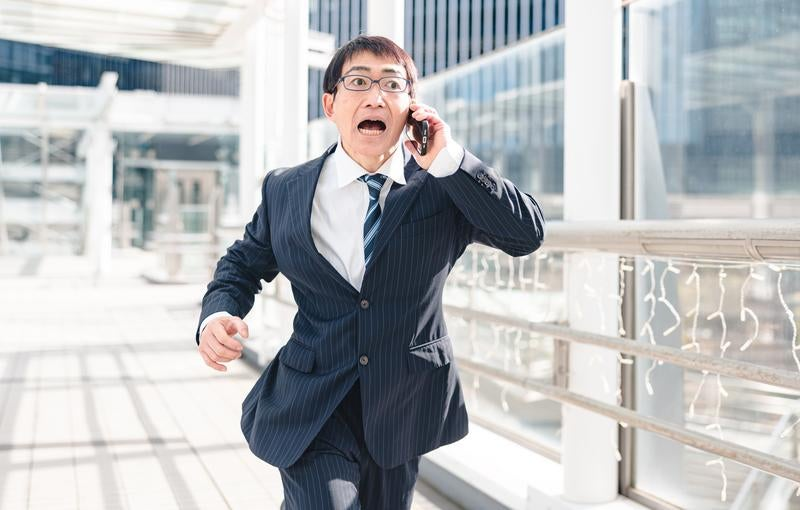

In [6]:
import cv2
from google.colab.patches import cv2_imshow

image = cv2.imread('sample.jpg')
cv2_imshow(image)

# 推論テスト

In [7]:
import onnxruntime

# ONNXモデルロード
onnx_session = onnxruntime.InferenceSession('cloths_segmentation.onnx', providers = ['CPUExecutionProvider'])
input_detail = onnx_session.get_inputs()[0]
output_detail = onnx_session.get_outputs()[0]
input_name = input_detail.name

In [8]:
# パディングサイズ計算用関数
def get_padding(h, w, unit_size):
    new_w = (w // unit_size + 1) * unit_size if w % unit_size != 0 else w
    new_h = (h // unit_size + 1) * unit_size if h % unit_size != 0 else h
    if h >= new_h:
        top = 0
        bottom = 0
    else:
        dh = new_h - h
        top = dh // 2
        bottom = dh // 2 + dh % 2
        h = new_h
    if w >= new_w:
        left = 0
        right = 0
    else:
        dw = new_w - w
        left = dw // 2
        right = dw // 2 + dw % 2
        w = new_w

    return (left, top, right, bottom)

In [9]:
import copy

import cv2
import numpy as np

# 画像読み込み
image = cv2.imread('sample.jpg')

# 前処理：パディング
image_width, image_hight = image.shape[1], image.shape[0]
padding = get_padding(image_hight, image_width, unit_size=32)

left, top, right, bottom = padding[0], padding[1], padding[2], padding[3]
pad_value = 0
padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=pad_value)

# 前処理：BGR→RGB
input_image = cv2.cvtColor(padded_image, cv2.COLOR_BGR2RGB)

# 前処理：標準化、BCHW変換
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
input_image = ((input_image / 255) - mean) / std
input_image = np.array(input_image, dtype=np.float32)
input_image = input_image.transpose(2, 0, 1)
input_image = input_image.reshape(-1, 3, padded_image.shape[0], padded_image.shape[1])

In [10]:
%%time

# 推論
onnx_result = onnx_session.run(None, {input_name: input_image})

CPU times: user 1.49 s, sys: 167 ms, total: 1.65 s
Wall time: 2.31 s


In [11]:
# 後処理：パディング除去、uint8化
mask = np.array(onnx_result[0][0][0])
mask = mask[top:top + image_hight, left:left + image_width]
mask = (mask > 0).astype('uint8')
mask = np.clip(mask * 255, 0, 255)

# 結果確認

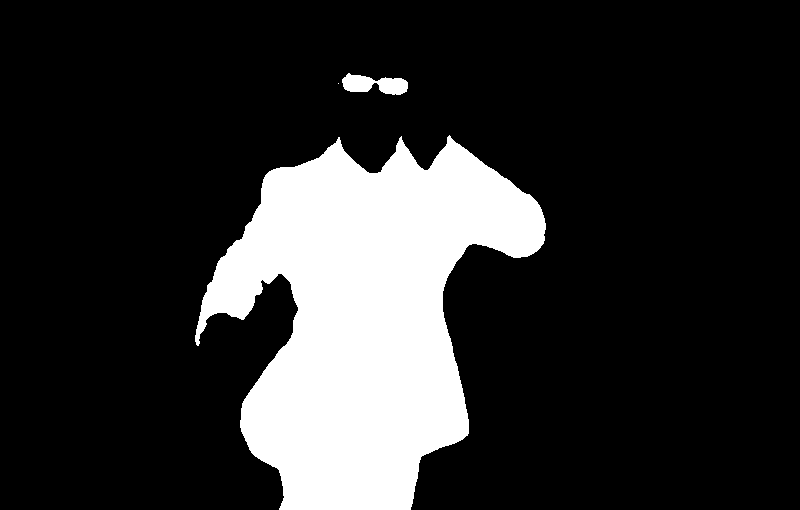

In [12]:
from google.colab.patches import cv2_imshow
cv2_imshow(mask)

In [13]:
# マスク画像を生成
resize_mask = cv2.resize(
    np.stack((mask, ) * 3, axis=-1).astype('float32'),
    dsize=(image.shape[1], image.shape[0]),
    interpolation=cv2.INTER_NEAREST,
)
resize_mask = np.where(resize_mask != 0, 0, 1)

# マスク画像と画像を合成
debug_image = copy.deepcopy(image)
bg_image = np.zeros(debug_image.shape, dtype=np.uint8)
bg_image[:] = [0, 255, 0]
mask_image = np.where(resize_mask, debug_image, bg_image)

# 半透明画像として合成
debug_image = cv2.addWeighted(debug_image, 0.5, mask_image, 0.5, 1.0)

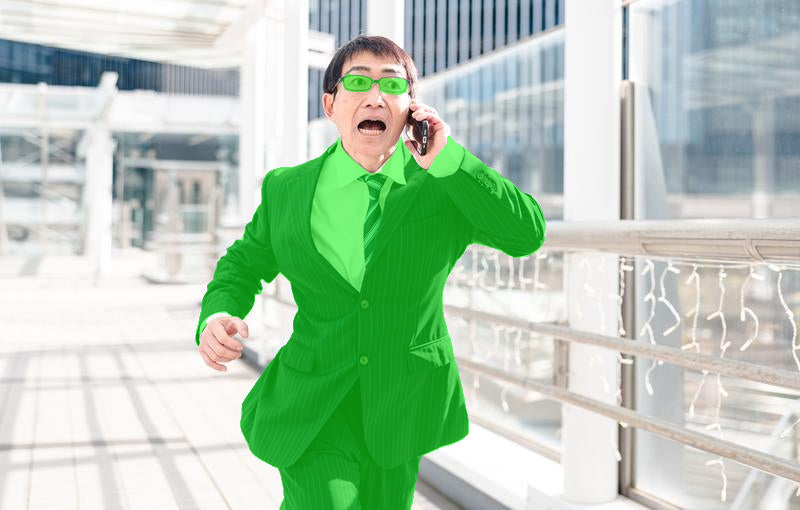

In [14]:
from google.colab.patches import cv2_imshow
cv2_imshow(debug_image)

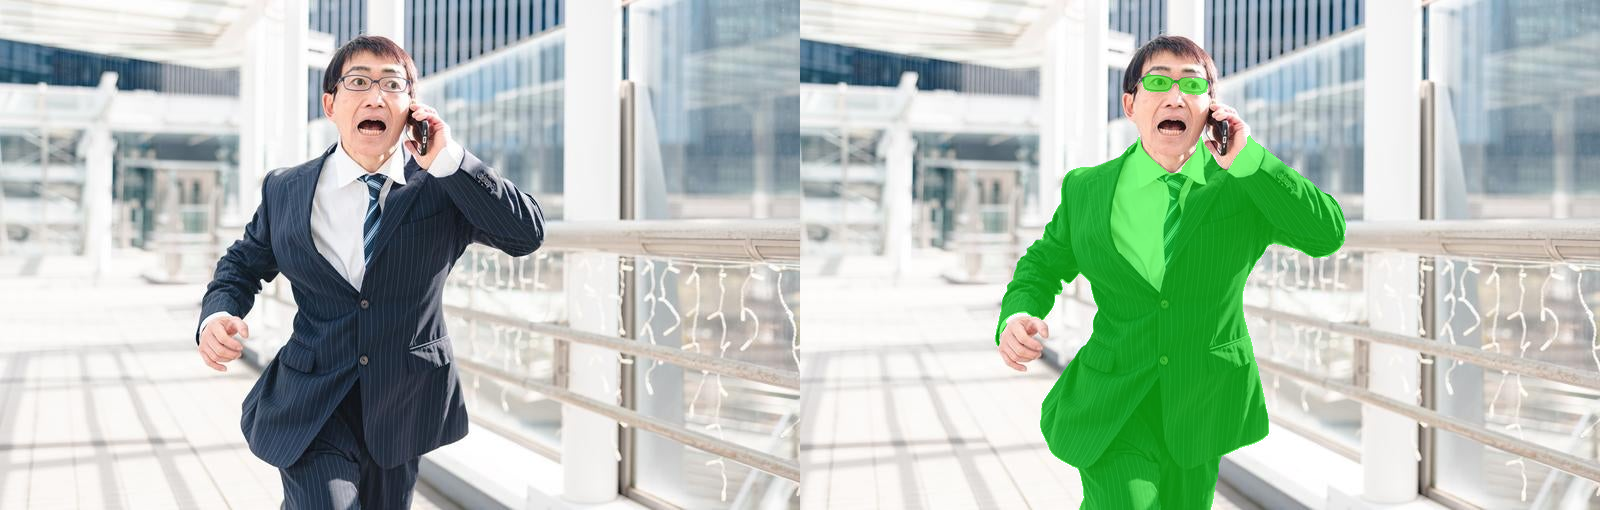

In [15]:
concat_image = cv2.hconcat([image, debug_image])
cv2_imshow(concat_image)